In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Load mm object from the file
filename = "morphmodel.pkl"
with open(filename, "rb") as file:
    mm = pickle.load(file)

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Real NVP flow architecture
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RealNVP, self).__init__()

        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim // 2, hidden_dim))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Linear(hidden_dim, input_dim // 2))
            layers.append(nn.LeakyReLU())

        self.net = nn.Sequential(*layers)
        self.scale = nn.Linear(input_dim // 2, input_dim // 2)
        self.translation = nn.Linear(input_dim // 2, input_dim // 2)

    def forward(self, x):
        x1, x2 = x.split(x.size(1) // 2, dim=1)
        s = self.scale(self.net(x1))
        t = self.translation(self.net(x1))
        y1 = x1 * torch.exp(s) + t
        y = torch.cat([y1, x2], dim=1)
        return y, s

    def inverse(self, y):
        with torch.no_grad():
            y1, y2 = y.split(y.size(1) // 2, dim=1)
            x1 = (y1 - self.translation(self.net(y1))) * torch.exp(-self.scale(self.net(y1)))
            return torch.cat([x1, y2], dim=1)


# Prepare your dataset (mm.scores) and normalize if necessary
dataset = mm.scores


# Convert the dataset to a PyTorch tensor and move it to the GPU
data_tensor = torch.tensor(dataset, dtype=torch.float32).cuda()

# Set the hyperparameters
input_dim = mm.scores.shape[1]
hidden_dim = 256
num_layers = 6
batch_size = 64


num_epochs = 10

# Create an instance of the Real NVP model and move it to the GPU
model = RealNVP(input_dim, hidden_dim, num_layers).cuda()

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0

    # Shuffle the dataset
    shuffled_indices = torch.randperm(data_tensor.size(0))
    shuffled_data = data_tensor[shuffled_indices]

    # Mini-batch training
    for i in range(0, shuffled_data.size(0), batch_size):
        batch = shuffled_data[i:i+batch_size]

        # Forward pass
        output, _ = model(batch)

        # Compute the loss
        loss = loss_fn(output, batch)
        epoch_loss += loss.item()

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Generate new samples
model.eval()
num_samples = 10
samples = model.inverse(torch.randn(num_samples, input_dim).cuda())

# Convert samples back to numpy array
generated_data = samples.detach().cpu().numpy()

torch.save(model.state_dict(), "scoreflow.pth")

Epoch [1/10], Loss: 1.1243
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [24]:
def show_samples(sample):
    generated_images = mm.reconstruct(sample)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(generated_images.reshape(3,64, 64)[0])
    ax[1].imshow(generated_images.reshape(3,64, 64)[1])
    ax[2].imshow(generated_images.reshape(3,64, 64)[2])

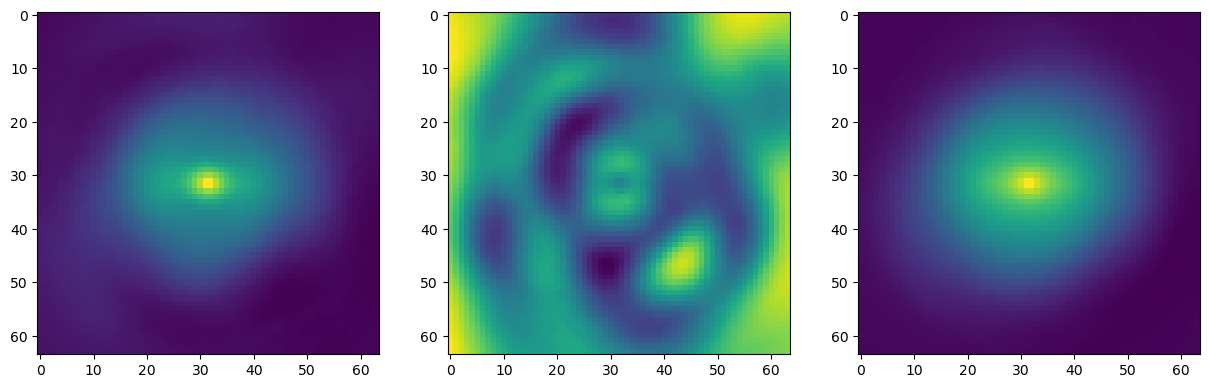

In [33]:
show_samples(generated_data[8])

In [76]:
galaxyimages = mm.datamatrix.reshape(mm.datamatrix.shape[0], 3, 64, 64)
pcaimgaes = mm.inverse_transformed_datamatrix.reshape(mm.datamatrix.shape[0], 3, 64, 64)
scores = mm.scores

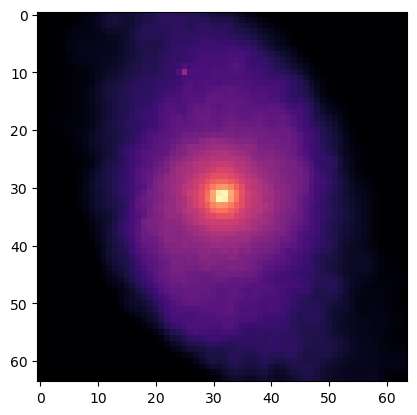

In [74]:
plt.imshow(galaxyimages[10][2], cmap = "magma")

In [81]:
scores1 = scores[23]
scores2 = scores[10]

def interpolate(scores1, scores2, n):
    # Convert the scores to tensors and move to GPU
    scores1_tensor = torch.tensor(scores1, dtype=torch.float32).cuda()
    scores2_tensor = torch.tensor(scores2, dtype=torch.float32).cuda()

    # Pass the scores through the inverse transformation of the normalizing flow model
    z1 = model.inverse(scores1_tensor.unsqueeze(0))
    z2 = model.inverse(scores2_tensor.unsqueeze(0))

    # Interpolate between the latent representations
    n_interp = torch.linspace(0, 1, n).unsqueeze(1).cuda()
    interp_z = torch.lerp(z1, z2, n_interp)

    # Convert the interpolated latent points back to the original data space
    interp_scores = model(interp_z)[0]

    return interp_scores.detach().cpu().numpy()

# Usage example
interpolated_scores = interpolate(scores1, scores2, n=10)

    

In [82]:
interpolated_scores.shape

(10, 60)

Interpolation video saved at interpolation_video.mp4


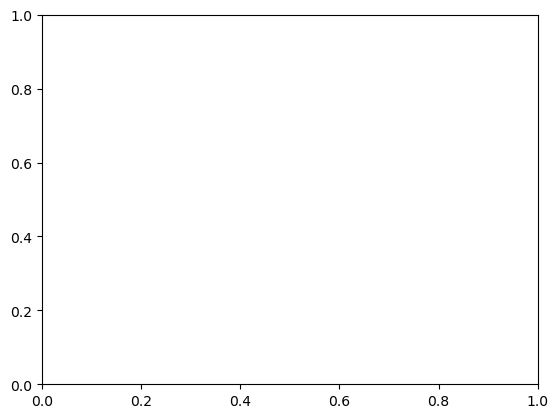

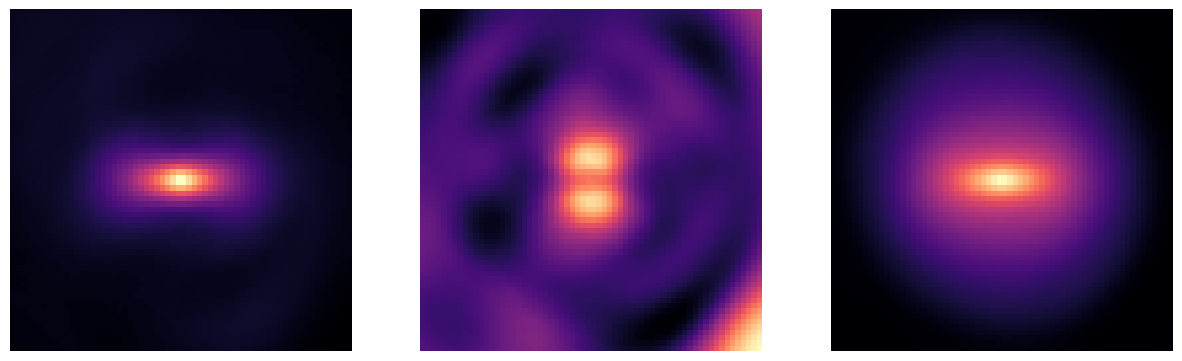

In [92]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the path and filename for the output video
output_video_path = "interpolation_video.mp4"

# Create an empty list to store the interpolated images
interpolated_images = []

# Perform the interpolation and store the interpolated images
interpolated_scores = interpolate(scores1, scores2, n=50)
for score in interpolated_scores:
    # Convert the scores back to the original image space (if needed)
    image = mm.reconstruct(score)  # Replace with your code to convert scores to images

    # Append the interpolated image to the list
    interpolated_images.append(image)

# Create a figure and axes for plotting
fig, ax = plt.subplots()

# Create an animation function to update the plot with interpolated images
fig, ax = plt.subplots(1,3, figsize=(15, 5))
def animate(i):
    ax[0].imshow(interpolated_images[i][0], cmap = "magma")
    ax[1].imshow(interpolated_images[i][1], cmap = "magma")
    ax[2].imshow(interpolated_images[i][2], cmap = "magma")
    [axi.set_axis_off() for axi in ax]
    return ax

# Create the animation using FuncAnimation
anim = animation.FuncAnimation(fig, animate, frames=len(interpolated_images), interval=200)

# Save the animation as a video file
anim.save(output_video_path, writer='ffmpeg')

# Print a message when the video creation is complete
print(f"Interpolation video saved at {output_video_path}")


